## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [1]:
import numpy as np
import math
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import joblib
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download('omw-1.4')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /Users/neo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/neo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/neo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/neo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [2]:
warnings.filterwarnings("ignore")
## Reading the data and removing columns that are not important. 
df = pd.read_csv("/Users/neo/CS6120/nlp-assignments/assignment1/movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
None  # print head of data frame with help of head function
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

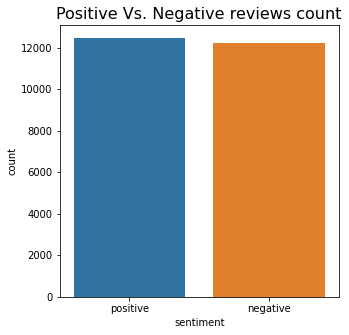

In [4]:
plt.figure(figsize = (5,5))
 
sns.countplot(x ='sentiment', data = df)
plt.title("Positive Vs. Negative reviews count", fontsize = 16)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [5]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment'] == 'positive']
df_minority = df[df['sentiment'] == 'negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([negative_upsample, df_majority])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [6]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
print(negative_upsample.shape)

(12474, 2)


### Expected Output : 
(12474, 2)

In [7]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
print(df_majority.shape)

(12474, 2)


### Expected Output : 
(12474, 2)

In [8]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[0:10000, :]
positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[0:10000, :]
## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:30000, :]
positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:30000, :]
## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train, positive_data_points_train])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train, positive_data_points_train])

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test, positive_data_points_test])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test, positive_data_points_test])

In [9]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
X_train['sentiment'].value_counts()
y_train['sentiment'].value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [10]:
X_test['sentiment'].value_counts()
y_test['sentiment'].value_counts()


negative    2474
positive    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [11]:
# TASK CELL
# used stemming operation for text-preprocessing
snowball = SnowballStemmer(language='english')
def clean_review(review):
    no_html = BeautifulSoup(review).get_text()
    clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
    clean = re.sub("(\s+)", " ", clean)
    clean = clean.lower()
    stopwords_en = stopwords.words("english")
    cleaned_stopwords = [w for w in re.split("\W+", clean) if not w in stopwords_en]
    stemmed_words = []
    for w in cleaned_stopwords:
        stemmed_words.append(snowball.stem(w))
    return stemmed_words

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [12]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    number_of_occurences = 0
    for k, n in frequency.items():
        if ((k[0] == word) and (k[1] == label)):
            return n
            
    return 0

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [13]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train['sentiment'] = y_train['sentiment'].map(output_map)
y_test['sentiment'] = y_test['sentiment'].map(output_map)

In [14]:
## Ensuring that there are equal number of classes on the training data. 
y_train['sentiment'].value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [15]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]['review']

"Horror/Sci-Fi that is interesting as it is laughable. F/X pretty good...for what you manage to see. A made for TV thriller that is not as bad as the worst of them. Jeffrey Coombs plays a brilliant although misguided scientist that tampers with stem cell research and manipulates human DNA with that of a hammerhead shark. The horrifying results give birth to one hell of a killing machine. A group of scientists led by William Forsythe and Hunter Tylo are invited to a remote island to check out the brilliant new experiment. Of course, after laughing and stammering in awe...Coombs' creation, by the way is his own son fused with a hammerhead, is let loose to hunt down one by one his father's colleagues. Revenge is not always rewarding. Also in the cast: Elsie Muller, G.R. Johnson, Arthur Roberts and Velizar Binev."

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [16]:
custom_review = X_train.iloc[0]['review']

# print cleaned review
print(clean_review(custom_review))

['horror', 'sci', 'fi', 'interest', 'laughabl', 'f', 'x', 'pretti', 'good', 'manag', 'see', 'made', 'tv', 'thriller', 'bad', 'worst', 'jeffrey', 'coomb', 'play', 'brilliant', 'although', 'misguid', 'scientist', 'tamper', 'stem', 'cell', 'research', 'manipul', 'human', 'dna', 'hammerhead', 'shark', 'horrifi', 'result', 'give', 'birth', 'one', 'hell', 'kill', 'machin', 'group', 'scientist', 'led', 'william', 'forsyth', 'hunter', 'tylo', 'invit', 'remot', 'island', 'check', 'brilliant', 'new', 'experi', 'cours', 'laugh', 'stammer', 'awe', 'coomb', 'creation', 'way', 'son', 'fuse', 'hammerhead', 'let', 'loos', 'hunt', 'one', 'one', 'father', 'colleagu', 'reveng', 'alway', 'reward', 'also', 'cast', 'elsi', 'muller', 'g', 'r', 'johnson', 'arthur', 'robert', 'velizar', 'binev', '']


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [17]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
        split_review = clean_review(review)
        for word in split_review:
          # Your code here
            target_tuple = (word, label)
            if (output_occurrence.get(target_tuple) != None):  
                output_occurrence[target_tuple] = output_occurrence[target_tuple]  + 1 
            else :
                output_occurrence[target_tuple] = 1
   
    return output_occurrence

### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [18]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [19]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train['review'], y_train['sentiment'])


In [20]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('horror', 1): 1723,
 ('sci', 1): 285,
 ('fi', 1): 287,
 ('interest', 1): 1981,
 ('laughabl', 1): 329,
 ('f', 1): 217,
 ('x', 1): 160,
 ('pretti', 1): 1661,
 ('good', 1): 5879,
 ('manag', 1): 580,
 ('see', 1): 5131,
 ('made', 1): 3501,
 ('tv', 1): 1095,
 ('thriller', 1): 394,
 ('bad', 1): 6518,
 ('worst', 1): 1905,
 ('jeffrey', 1): 40,
 ('coomb', 1): 2,
 ('play', 1): 2805,
 ('brilliant', 1): 223,
 ('although', 1): 801,
 ('misguid', 1): 43,
 ('scientist', 1): 222,
 ('tamper', 1): 7,
 ('stem', 1): 20,
 ('cell', 1): 118,
 ('research', 1): 149,
 ('manipul', 1): 69,
 ('human', 1): 706,
 ('dna', 1): 10,
 ('hammerhead', 1): 7,
 ('shark', 1): 89,
 ('horrifi', 1): 57,
 ('result', 1): 448,
 ('give', 1): 2237,
 ('birth', 1): 58,
 ('one', 1): 10831,
 ('hell', 1): 549,
 ('kill', 1): 1811,
 ('machin', 1): 176,
 ('group', 1): 509,
 ('led', 1): 120,
 ('william', 1): 216,
 ('forsyth', 1): 5,
 ('hunter', 1): 139,
 ('tylo', 1): 2,
 ('invit', 1): 96,
 ('remot', 1): 203,
 ('island', 1): 383,
 ('check', 1)

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = []
    for wordPair in freqs.keys():
        if wordPair[0] not in vocab :
                vocab.append(wordPair[0])           
    V = len(vocab)
    
    

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    #for pair in frequency_dict.keys():
    for pair in freqs.keys():
        # if the label is zero.
        if pair[1] == 0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos = num_pos + freqs.get(pair);
        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            num_neg = num_neg + freqs.get(pair);

    # Calculate num_doc, the number of documents
    num_doc = train_x['sentiment'].value_counts()

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = len(train_y[train_y['sentiment'] == 0])

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = len(train_y[train_y['sentiment'] == 1])
    # Calculate logprior
    logprior = math.log(neg_num_docs) - math.log(pos_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        
        target_tuple_positive = (word, 0)
        target_tuple_negative = (word, 1) 
        freq_pos = freqs.get(target_tuple_positive)
        if(freq_pos is None):
            freq_pos = 0;
        freq_neg = freqs.get(target_tuple_negative)
        if(freq_neg is None):
            freq_neg = 0;

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)
        
        # calculate the log likelihood of the word
        loglikelihood[word] = math.log((p_w_neg/p_w_pos))
    
    return logprior, loglikelihood

In [22]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
43670


In [23]:
# store the model parameters in a local file to be used by the classifier
with open('naive_bayes_model_parameters.pkl', 'wb') as f:
    pickle.dump( train_naive_bayes(freqs, X_train, y_train), f)

### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [24]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
    
      # process the review to get a list of words
    word_l = clean_review(review)

    # initialize probability to zero
    total_prob = 0
    prediction = 0

    # add the logprior
    total_prob = total_prob + logprior
    

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if (word in loglikelihood):
            # add the log likelihood of that word to the probability
            total_prob = total_prob + loglikelihood[word]
                   
    if(total_prob > 0.0):
        prediction = 1
    if(total_prob <= 0.0):
        prediction = 0

    return prediction




In [25]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [32]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  
    matched_result = 0
    
    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        prediction = naive_bayes_predict(review, logprior, loglikelihood)
        #if None:
        if (prediction == 1):
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    total_difference = 0
#     print(y_hats)
#     print(test_y)
    
    for idx, x in enumerate(test_y):
        total_difference = total_difference + abs(y_hats[idx] - x)
        if(y_hats[idx] == x):
            matched_result = matched_result + 1
    error = total_difference / len(y_hats)
    accuracy = 1 - error

    return accuracy,y_hats,matched_result


In [27]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [28]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [33]:
#Split your data into training and test sets using random selection. 
#Set the seed as parameter of the function so that user can select a 
#different training and test set by changing seed 

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score

def evaluate_accuracy(seedValue):
    X = df_upsampled
    y = df_upsampled
   
    #Q1:Split your data into training and test sets using random selection. Set the seed as parameter of the function 
    #so that user can select a different training and test set by changin seed.
    X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X, y, test_size=seedValue)
    output_map = {'positive': 0, 'negative': 1}
    y_train_eval['sentiment'] = y_train_eval['sentiment'].map(output_map)
    y_test_eval['sentiment'] = y_test_eval['sentiment'].map(output_map)
    
    # accurancy evaluation for training data set
    freqs = review_counter({}, X_train_eval['review'], y_train_eval['sentiment'])
    #Q2:Calculate model paramters with training set.
    logprior, loglikelihood = train_naive_bayes(freqs, X_train_eval, y_train_eval) 
    accuracy, y_train_pred, matched_result = test_naive_bayes(X_train_eval['review'],y_train_eval['sentiment'], logprior, loglikelihood)
    
    #Q3:Print confusion matrix for training and test set.
    print(metrics.confusion_matrix(y_train_eval['sentiment'], y_train_pred))
    print('Accuracy for training data is:',accuracy)
    accuracy, y_train_pred,matched_result = test_naive_bayes(X_test_eval['review'], y_test_eval['sentiment'], logprior, loglikelihood) 
    print(metrics.confusion_matrix(y_test_eval['sentiment'],  y_train_pred))
    print('Accuracy for test data is:', accuracy)
    

In [30]:
#Q4:Examine False Positive and False Negative cases and provide reasoning why they get misclassified.
False negative case:
Review: The movie is good.
Reasoning: The probability of the word "movie" is 0.29363059089434607 and that of "good" is -0.0036938593431549366.
        When we use the word "movie" alone we get a probability greater than 0 leading us to get a prediction of 1.
        But when we use the word good alone it rightfully gives a prediction of 0 i.e positive. But since the probability 
        value of the word "movie" is quite high we end up with a summed loglikelihood value of greater than 0 and 
        thus a negative prediction. More occurence of the word movie as part of positive review would have helped us to 
        get a better prediction.
        
False positive case:
Review:  Some might say that it is awesome, good, mindblowing, I personally did not like it.        
Reasoning: Although the review is clearly negative, due to use of some positive words, our loglikelihood value summed 
        upto -1.8401437053512373 giving us a positive prediction.
        For eg:- probability of "awesome" is -1.0595567113375304, probability of "good" is -0.0036938593431549366,
        probability of "mindblowing" is -1.3657235984634144 and that of "did not like"  0.2066322448821285.
        Clearly we have bigger values for positive words the total loglikelihood value is negative and thus we got a prediction 
        of false positive.
            

SyntaxError: invalid syntax (4241757914.py, line 2)

In [34]:
evaluate_accuracy(0.2)

[[8874 1098]
 [ 577 9409]]
Accuracy for training data is: 0.9160737548852591
[[2095  407]
 [ 242 2246]]
Accuracy for test data is: 0.869939879759519


# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

In [637]:
Laplace smoothing is a smoothing technique that handles the problem of zero probability in Naïve Bayes. 
Using Laplace smoothing, we can represent P(w’|positive) as
 
    P(w’|positive) = (number of reviews with w’ and y = positive + ⍺) / (N + ⍺ * k)

Here,
alpha represents the smoothing parameter,
K represents the number of dimensions (features) in the data, and
N represents the number of reviews with y=positive
If we choose a value of alpha!=0 (not equal to 0), the probability will no longer be zero even if a word is not present in the training dataset.


If the training data has a different frequency distribution compared to the test set, the Naive Bayes classifier performs poorly. The classifier is especially affected by values not being represented in the training set.

If the model comes across a categorical feature that isn’t present in the training set, the probability of 0 is assigned to that new category. This is very dangerous, 
as multiplying 0 with other features’ probabilities will result in 0. 

Even when we use the log probabilities, the zero observation problem exists. Because log(0) = -\inf, and summation with \inf will cancel out all the valid information from other features.

We need to check for these cases and take action if the test data set has zero frequency issues. The most known approach is to use Laplace Smoothing. In this technique, we add a parameter to both numerator 
and denominator when calculating the class probabilities.

For example, we can add a smoothing parameter (of 1) when calculating the class probabilities:

  \[P(C|A) = \frac{P(A |C) P(C) + 1}{P(A) + 1}\]

The smoothing parameter ensures that the probability value is never zero. 
Applying a smoothing technique assigns a very small probability estimate to such zero frequency occurrences, hence, regularize the Naive Bayes classifier. 



Not having additive smoothing leads to bad outcomes due to the following reason:
Essentially, in Naive Bayes, we do inference on a test sequence  𝐱=(𝑥1,𝑥2,…,𝑥𝑛)  using the following equation:

𝑦𝑝𝑟𝑒𝑑=argmax𝑦𝑃(𝑦)𝑃(𝑥1|𝑦)𝑃(𝑥2|𝑦)…𝑃(𝑥𝑛|𝑦) 

The probabilities in the above equation are estimated from the training data, typically by simply counting the no. of occurrences of each event [which is equivalent to the maximum likelihood estimate]. Now, suppose we are solving a spam classification task using the above, and in our training data, we see the word ‘buy’ only in spam emails, and never in non-spam emails. Therefore, our estimate will tell us that  𝑃(buy|not-spam)=0 , that is, no non-spam email will contain the word ‘buy’. Now, clearly, this is not true. The probability of this event is low, but it is not zero. Further, because we are multiplying all the probabilities during inference, even one such zero probability term will lead to the entire process failing.

Therefore, we need smoothing — the goal is to increase the zero probability values to a small positive number [and correspondingly reduce other values so that the sum is still 1]. Laplace smoothing is one such method.

To explain Laplace smoothing without going into the math, in the above example, we will assume that we have “additional emails” in our training data — one spam email with all the English words, and one non-spam email with all the English words. This ensures that every word appears at least once in each category. So our counts change as follows:

If initially, we had 20 spam emails and 80 non-spam emails, we had  𝑃(spam)=0.20  and  𝑃(not-spam)=0.80 . This now changes to 21 spam emails and 81 non-spam emails making  𝑃(spam)=0.21  and  𝑃(not-spam)=0.79 .
Similarly, if we originally had ‘buy’ in 5 out of 20 spam emails and in no non-spam emails, we had  𝑃(buy|spam)=0.25  and  𝑃(buy|not-spam)=0 . Now, we have ‘buy’ in 6 out of 21 spam emails and in 1 out of 81 non-spam emails changing the probabilities to  𝑃(buy|spam)=0.29  and  𝑃(buy|not-spam)=0.01 .
If we are familiar with Bayesian approach, the above is equivalent to imposing a uniform prior over our events.

Finally, there is nothing specific about smoothing to Naive Bayes. Any time we use counts to estimate parameters, which can lead to zero values , we should use smoothing.





SyntaxError: invalid syntax (4014450903.py, line 1)

In [ ]:
Multiplying very small numbers will lead to even smaller numbers. It is difficult to precisely store 
and compare these very small numbers. We face these problems when working with probability values.

To avoid working with very small numbers, we can work within the log probability space 
by taking the logarithm of probability values.

The log function maps the probability values from [0, 1] range to the (- \inf, 0] range. 
Thus, the log probability values will be negative.The smaller the actual probability value is, 
it’ll be mapped to a larger negative value by the log function.
We need to remember that multiplication operation becomes an addition in the logarithm space. 
So, taking the logarithm of the whole equation gives us:
                  m
 log (P(C_i/A)) ∝ (∑) log (P(aj/C_i))log (P(C_i))            [the predicted class C_i,]
                  j=1                                        [A represents an observation with m attributes: [A = {a_1, a_2, ..., a_m}\]]         
                                                                                       
This mapping approach works because to classify in Naive Bayes, we need to know which class has the
largest probability rather than what the specific probability is. 
Taking the logarithm will not change the ordering of class label probability scores. 
Hence, we can still decide which class has the highest probability.
                                                                       
                                                                       